# LLP Jet Selection: Simple

For the first version of the analysis we want to look at some very simple jet properties to select CalRatio jets: $\log(\frac{HAD}{EM})$ (old-skool).

1. Look at jet $p_T$ range for our low and high mass signal samples, LLP and non-LLP jets.
1. Use J3 or J4, depending on the $p_T$ range, as a background sample
1. Look at $\log(\frac{HAD}{EM})$ for the signal and background
1. A quick optimization test to see where we should put a cut.


## Setup

In [1]:
import sys, os
sys.path.append(os.pardir)

from typing import Optional
import matplotlib.pyplot as plt

from hl_tables import histogram

from calms.data import get_ds, as_single_sample, as_samples

In [2]:
# Turn on to help with debugging the back end. :-)
# import logging
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# logging.getLogger('servicex').setLevel(logging.DEBUG)
# logging.getLogger('servicex').addHandler(ch)
# logging.getLogger('dataframe_expressions').setLevel(logging.DEBUG)
# logging.getLogger('dataframe_expressions').addHandler(ch)

## Data Samples

In [3]:
def name_sample(s: dict, name: Optional[str] = None):
    n = name if name is not None else f'{s["mH"]}-{s["mS"]}'
    s.update({'name': n})
    
high_mass = as_single_sample(get_ds(tag='highmass'))
name_sample(high_mass)
low_mass = as_single_sample(get_ds(tag='lowmass'))
name_sample(low_mass)

def get_jz(tag):
    jz = as_samples(get_ds(tag=tag))[0]
    name_sample(jz, tag.upper())
    return jz

all_samples = [low_mass, high_mass, get_jz('jz3'), get_jz('jz4'), get_jz('jz5')]

## Jet $p_T$

Understand what samples are best to examine this by comparing the $p_T$ spectra.

In [4]:
def define_global_aliases(ds):
    from dataframe_expressions import define_alias
    define_alias('', 'ptgev', lambda o: o.pt / 1000.0)
    
def define_loose_jets(ds):
    'Establish loose jets as a part of the dataset'
    # TODO: Add good-jet criteria to the definition
    all_jets = ds.Jets('AntiKt4EMTopoJets')
    loose_jets = all_jets[(all_jets.ptgev > 35.0) & (abs(all_jets.eta) < 2.5)]
    ds['loose_jets'] = loose_jets
    
def define_ds(ds):
    define_global_aliases(ds)
    define_loose_jets(ds)

In [5]:
for s in all_samples:
    define_ds(s['data'])

In [6]:
def plot_pt(ds, func=lambda d: d.loose_jets.ptgev):
    histogram(func(ds['data']), bins=200, range=(0,800))
    _ = plt.ylabel('Count')
    _ = plt.title(ds['name'])
    _ = plt.xlabel('$p_T$ [GeV]')

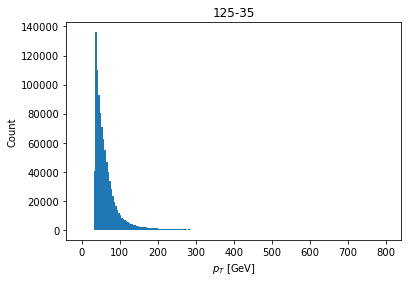

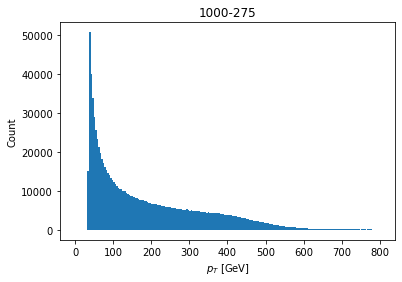

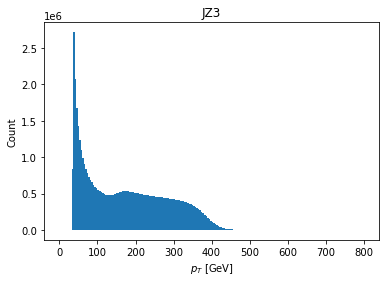

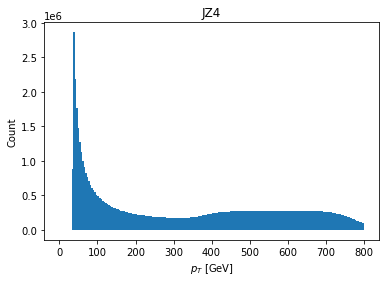

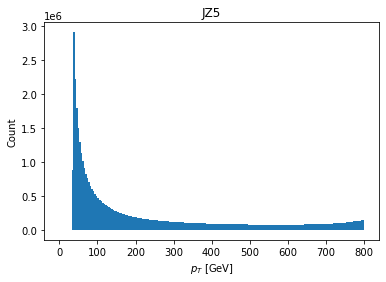

In [7]:
for s in all_samples:
    plot_pt(s)

Next task is to setup something that will mark jets as being LLP or not. We steal this from a tutorial that was done earlier:

- Add a IsLLP flag to each jet which can be filtered on
- Only do this for the signal samples
- Provide information for later on Lxy, etc. for those jets that have IsLLP true.

In [8]:
# Define DeltaR function availible on servicex (see the functions intro for more info)
from dataframe_expressions import user_func

@user_func
def DeltaR(p1_eta: float, p1_phi: float, p2_eta: float, p2_phi: float) -> float:
    '''
    Calculate the DeltaR between two particles given their `eta` and `phi` locations.
    Implemented on the back end.
    '''
    assert False, 'This should never be called'

def associate_particles(source, pick_from, name: str):
    '''
    Associate each particle from source with a close by one from the particle list pick_from. Extend source's data model.
    
    Args:
        source            The particles we want to start from
        pick_from         For each partcile from source, we'll find a close by one from pick_form.
        name              Naming we can use when we extend the data model.
        
    Returns:
        with_assoc        The source particles that had a close by match
    '''
    def dr(p1, p2):
        'short hand for calculating DR between two particles.'
        return DeltaR(p1.eta(), p1.phi(), p2.eta(), p2.phi())

    def very_near(picks, p):
        'Return all particles in picks that are DR less than 0.1 from p'
        return picks[lambda ps: dr(ps, p) < 0.2]

    source[f'all_LLP'] = lambda source_p: very_near(pick_from, source_p)
    
    source[f'is_LLP'] = lambda e: e.all_LLP.Count() > 0
    with_assoc = source[source.is_LLP]
    with_assoc['matched_LLP'] = lambda e: e.all_LLP.First()
    
    return with_assoc

We'll get the MC particles and the loose jets to establish the connection.

In [9]:
def do_a_sample(df):
    mc_part = df.TruthParticles('TruthParticles')
    mc_llp = mc_part[mc_part.pdgId == 35]

    def good_mc(mc):
        'Good electron particle'
        return (mc.ptgev > 20) & (abs(mc.eta) < 2.5)

    good_mc_llp = mc_llp[good_mc]

    return associate_particles(df.loose_jets, good_mc_llp, 'LLP')

In [10]:
for s in all_samples:
    if 'signal' in s['tags']:
        s['data']['loose_jets_LLP'] = do_a_sample(s['data'])

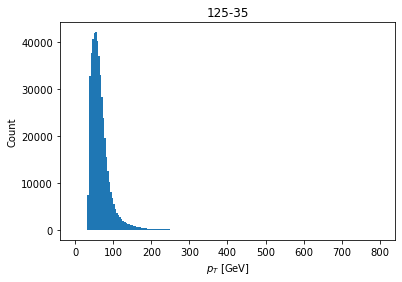

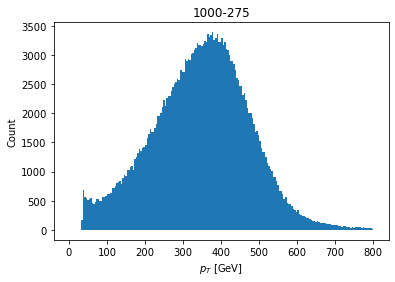

In [11]:
for s in all_samples:
    if 'signal' in s['tags']:
        plot_pt(s, func=lambda d: d.loose_jets_LLP.ptgev)